In [389]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import openmc
import os 
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys 
from PIL import Image
import numpy as np

CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[2]
sys.path.append(str(project_root))

from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
from parameters.parameters_materials import (B4C_MATERIAL, HELIUM_MATERIAL, AIR_MATERIAL, LEAD_MATERIAL, STEEL_MATERIAL, CONCRETE_MATERIAL)
from src.utils.pre_processing.pre_processing import *
from src.utils.post_preocessing.post_processing import *
os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS

In [390]:
materials = openmc.Materials([B4C_MATERIAL, HELIUM_MATERIAL, AIR_MATERIAL, LEAD_MATERIAL, STEEL_MATERIAL, CONCRETE_MATERIAL])

In [391]:
COORDINATES_CONTROL_RODS = {
    "rod_1": {"x": 0.0, "y": 0.0, "z": 0.0},
    "rod_2": {"x": 10.0, "y": 0.0, "z": 0.0},
    "rod_3": {"x": -10.0, "y": 0.0, "z": 0.0},
    "rod_4": {"x": 0.0, "y": 10.0, "z": 0.0},
    "rod_5": {"x": 0.0, "y": -10.0, "z": 0.0},
    "rod_6": {"x": 10.0, "y": 10.0, "z": 0.0},
    "rod_7": {"x": -10.0, "y": -10.0, "z": 0.0},
    "rod_8": {"x": 10.0, "y": -10.0, "z": 0.0},
    "rod_9": {"x": -10.0, "y": 10.0, "z": 0.0},
}

# Surfaces
steel_part_control_rods = openmc.Cylinder(r=4.0, surface_id=1)
helium_part_control_rods = openmc.Cylinder(r=3.3, surface_id=2)
b4c_part_control_rods = openmc.Cylinder(r=2.8, surface_id=3)

plane_top = openmc.ZPlane(z0=50.0, surface_id=300)
plane_bottom = openmc.ZPlane(z0=-50.0, surface_id=301)

detector = openmc.Sphere(x0=70., r=10.0, surface_id=302)
outer_boundary = openmc.Sphere(r=200.0, surface_id=303, boundary_type='vacuum')



/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=1.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=2.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=3.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=300.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=301.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packag

In [392]:
# Control Rods
# liner_steel_control_rod = openmc.Cell(name="liner_steel_control_rod")
# liner_steel_control_rod.fill = STEEL_MATERIAL
# liner_steel_control_rod.region = -steel_part_control_rods & +helium_part_control_rods & -plane_top & +plane_bottom

# helium_control_rods = openmc.Cell(name="helium_control_rods")
# helium_control_rods.fill = HELIUM_MATERIAL
# helium_control_rods.region = -helium_part_control_rods & +b4c_part_control_rods & -plane_top & +plane_bottom

# b4c_control_rods = openmc.Cell(name="b4c_control_rods")
# b4c_control_rods.fill = B4C_MATERIAL
# b4c_control_rods.region = -b4c_part_control_rods & -plane_top & +plane_bottom

# Define the other 8 control rods
control_rods = []
for i, rod_name in enumerate([k for k in COORDINATES_CONTROL_RODS], start=2):
    coords = COORDINATES_CONTROL_RODS[rod_name]
    # Shift the cylinders to the correct position for each rod
    steel_cyl = openmc.Cylinder(x0=coords["x"], y0=coords["y"], r=4.0, surface_id=10*i+1)
    helium_cyl = openmc.Cylinder(x0=coords["x"], y0=coords["y"], r=3.3, surface_id=10*i+2)
    b4c_cyl = openmc.Cylinder(x0=coords["x"], y0=coords["y"], r=2.8, surface_id=10*i+3)

    steel_cell = openmc.Cell(name=f"liner_steel_control_rod_{rod_name}")
    steel_cell.fill = STEEL_MATERIAL
    steel_cell.region = -steel_cyl & +helium_cyl & -plane_top & +plane_bottom

    helium_cell = openmc.Cell(name=f"helium_control_rod_{rod_name}")
    helium_cell.fill = HELIUM_MATERIAL
    helium_cell.region = -helium_cyl & +b4c_cyl & -plane_top & +plane_bottom

    b4c_cell = openmc.Cell(name=f"b4c_control_rod_{rod_name}")
    b4c_cell.fill = B4C_MATERIAL
    b4c_cell.region = -b4c_cyl & -plane_top & +plane_bottom

    control_rods.extend([steel_cell, helium_cell, b4c_cell])

# Add the other control rods to the universe
detector_cell = openmc.Cell(name="detector_cell")
detector_cell.fill = HELIUM_MATERIAL
detector_cell.region = -detector

air_region = -outer_boundary & ~detector_cell.region
air_cell = openmc.Cell(name="air_cell", fill=AIR_MATERIAL, region=air_region)
 
universe = openmc.Universe(cells=[ detector_cell, air_cell ])
universe.add_cells(control_rods)


geometry = openmc.Geometry(universe)

/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=21.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=22.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=23.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=31.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=32.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packa

In [393]:
geometry.export_to_xml()
materials.export_to_xml()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

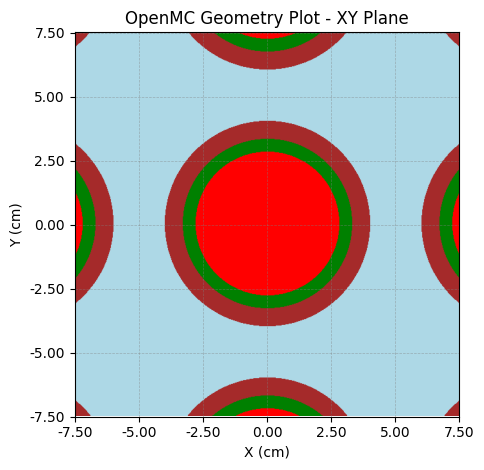

In [394]:
plot_geometry(materials=materials, width=15, height=15, saving_figure=False, color_by="material")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

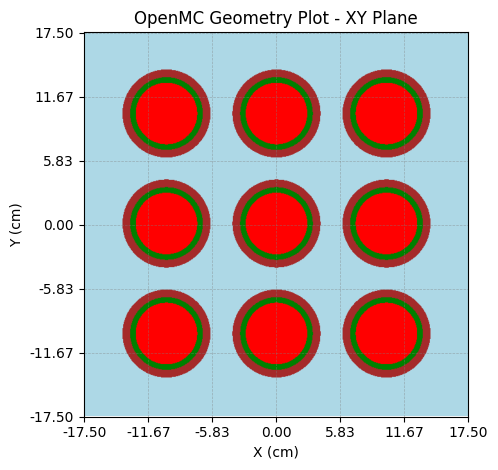

In [395]:
plot_geometry(materials=materials, width=35, height=35, saving_figure=False, color_by="material")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

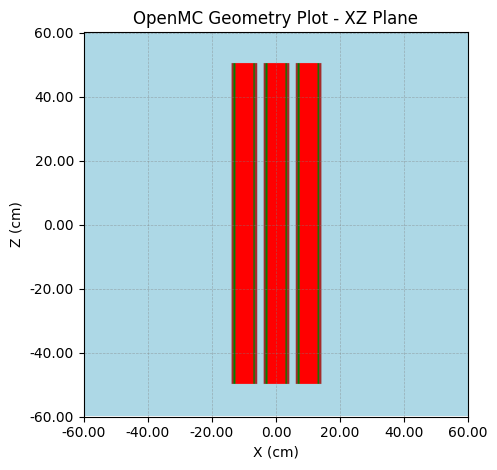

In [396]:
plot_geometry(materials=materials, width=120, height=120, plane="xz", saving_figure=False)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

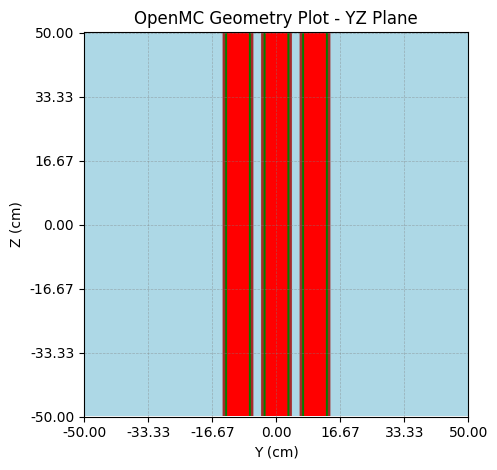

In [397]:
plot_geometry(materials=materials, width=100, height=100, plane="yz", saving_figure=False)

In [398]:
sources = []
for coords in COORDINATES_CONTROL_RODS.values():
    x = coords["x"]
    y = coords["y"]
    r = openmc.stats.PowerLaw(3.3, 4.0, 1.0) # from 3.3 to 4.0 cm
    phi = openmc.stats.Uniform(0, 2*np.pi)
    z = openmc.stats.Uniform(-50.0, 50.0)
    source = openmc.IndependentSource()
    source.space = openmc.stats.CylindricalIndependent(r=r, phi=phi, z=z, origin=(x, y, 0))
    source.angle = openmc.stats.Isotropic()
    source.energy = openmc.stats.Discrete([661_700], [1.0])
    source.particle = "photon"
    sources.append(source)


In [399]:
tallies = openmc.Tallies([])
mesh_tally_xy = mesh_tally_plane(plane="xy", particule_type="photon", name_mesh_tally="flux_mesh_xy")
tallies.append(mesh_tally_xy)

mesh_tally_yz = mesh_tally_plane(plane="xz", particule_type="photon", name_mesh_tally="flux_mesh_yz")
tallies.append(mesh_tally_yz)

In [400]:
# Configuration de la simulation
settings = openmc.Settings()
batches_number = 30
settings.batches = batches_number
settings.particles = 10**6
settings.source = sources
settings.uniform_source_sampling = True
settings.photon_transport = True
settings.run_mode = "fixed source"
settings.verbose = True

In [401]:
settings.export_to_xml()
tallies.export_to_xml()

/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=50.
  warn(msg, IDWarning)


In [402]:
remove_previous_results(batches_number)
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [403]:
sp = openmc.StatePoint(f"statepoint.{batches_number}.h5")

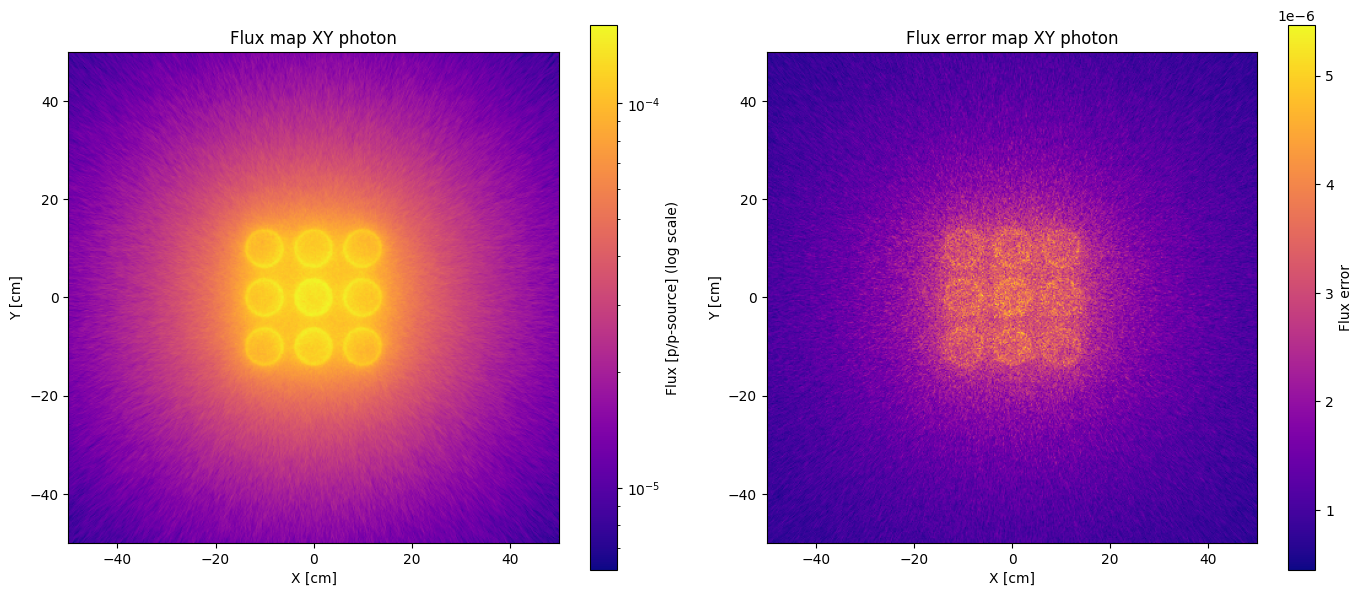

In [404]:
load_mesh_tally(statepoint_file=sp, cwd = CWD, name_mesh_tally="flux_mesh_xy", particule_type="photon",
                plane = "xy", upper_right=(50, 50), lower_left=(-50, -50),
                zoom_x=(-50, 50), zoom_y=(-50, 50), saving_figure=False, plot_error=True)

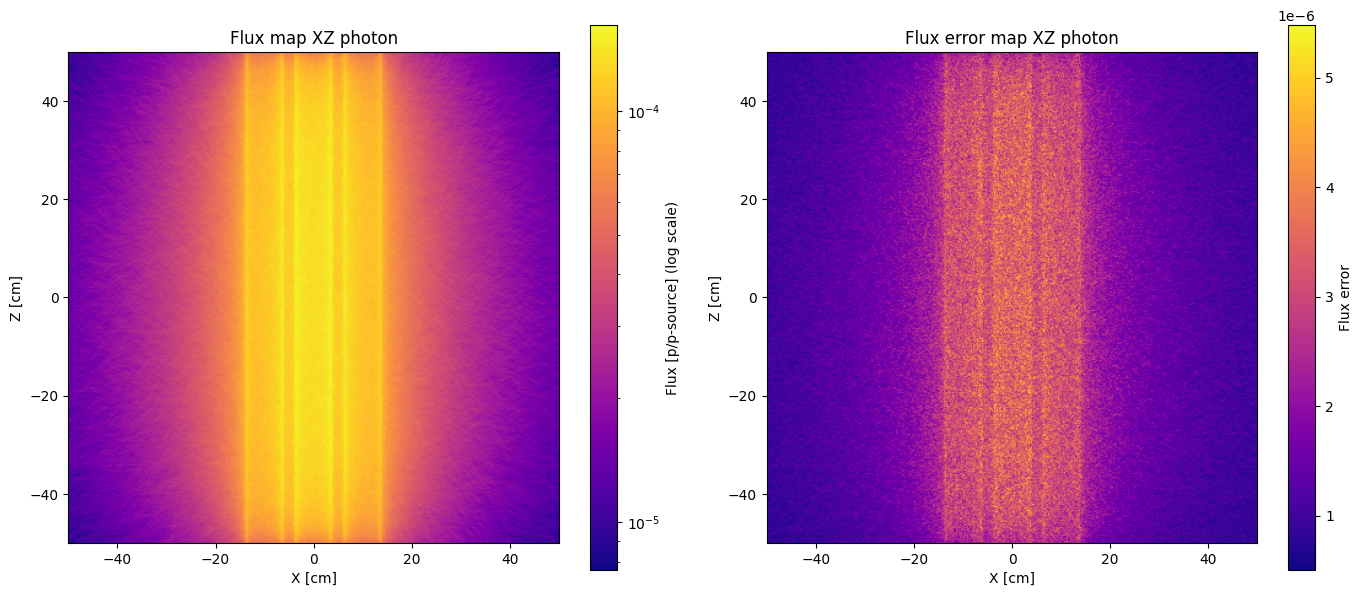

In [405]:
load_mesh_tally(statepoint_file=sp, cwd = CWD, name_mesh_tally="flux_mesh_yz", particule_type="photon",
                plane = "xz", upper_right=(50, 50), lower_left=(-50, -50),
                zoom_x=(-50, 50), zoom_y=(-50, 50), saving_figure=False, plot_error=True)